# Make a schematic of spike versus effective number of amino acids at each site using Nextstrain open data

In [64]:
import collections
import json
import math
import os

import Bio.SeqIO

import dna_features_viewer

from IPython.display import display, HTML

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
domain_annotated = Bio.SeqIO.read("data/NC_045512.2.gp", 'genbank')

In [77]:
with open("data/ncov_open_global_all-time.json") as f:
    nextstrain_data = json.load(f)

tree = nextstrain_data["tree"]

def traverse_tree(n, tipslist, spike_aas):
    spike_aas = spike_aas.copy()
    if "S" in n["branch_attrs"]["mutations"]:
        aas = n["branch_attrs"]["mutations"]["S"]
        for m in aas:
            spike_aas[int(m[1: -1])] = m[-1]
    if "children" in n and n["children"]:
        for c in n["children"]:
            traverse_tree(c, tipslist, spike_aas)
    else:
        tips.append(spike_aas)

tips = []
traverse_tree(tree, tips, {})

aa_counts = {r: {} for r in range(1, len(domain_annotated))}
for tip in tips:
    assert set(tip).issubset(aa_counts)
    for r in aa_counts:
        if r in tip:
            aa = tip[r]
        else:
            aa = "wt"
        if aa in aa_counts[r]:
            aa_counts[r][aa] += 1
        else:
            aa_counts[r][aa] = 1

entropy = {}
for r, counts in aa_counts.items():
    tot = sum(counts.values())
    assert tot == len(tips)
    entropy[r] = 0.0
    if len(counts) > 1:
        for n in counts.values():
            entropy[r] -= (n / tot) * math.log(n / tot)

df = pd.Series(entropy).rename("entropy").rename_axis("site").reset_index().assign(
    neff=lambda x: x["entropy"].map(lambda h: math.exp(h))
)

df

,site,entropy,neff
0,1,0.000000,1.000000
1,2,0.000000,1.000000
2,3,0.041242,1.042105
3,4,0.000000,1.000000
4,5,0.056065,1.057666
...,...,...,...
1267,1268,0.000000,1.000000
1268,1269,0.000000,1.000000
1269,1270,0.000000,1.000000
1270,1271,0.000000,1.000000


In [104]:
# Read site escape
dms = (
    pd.read_csv("../results/summaries/sera_group_avgs.csv")
    .query("`spike mediated entry` >= -2")
    .query("`ACE2 binding` >= -2")
    .groupby("site", as_index=False)
    .aggregate(
        imprinted_adults=pd.NamedAgg("imprinted adults escape", lambda s: s.clip(lower=0).sum()),
        primary_infants=pd.NamedAgg("XBB infected infants escape", lambda s: s.clip(lower=0).sum()),
    )
    .assign(site0=lambda x: x["site"] - 1)
)
dms

,site,imprinted_adults,primary_infants,site0
0,1,0.000000,0.000000,0
1,2,0.061590,0.006600,1
2,3,0.289720,0.113930,2
3,4,0.031000,0.295680,3
4,5,0.035050,0.081890,4
...,...,...,...,...
1226,1248,0.000000,0.000000,1247
1227,1249,0.001758,0.055610,1248
1228,1250,0.004769,0.172045,1249
1229,1251,0.010482,0.151730,1250


/fh/fast/bloom_j/software/miniforge3/envs/BloomLab/lib/python3.12/site-packages/Bio/SeqFeature.py:239: BiopythonDeprecationWarning: Please use .location.strand rather than .strand
  warnings.warn(
/tmp/ipykernel_38084/573124744.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax_var.set_xticklabels([(int(i + 1)) for i in ax_var.get_xticks()])
/tmp/ipykernel_38084/573124744.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


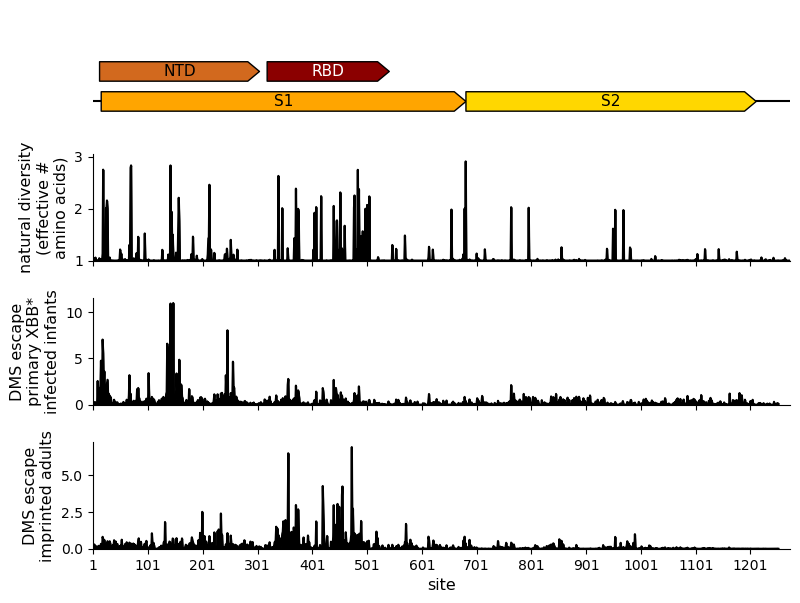

In [128]:
class SpikeTranslator(dna_features_viewer.BiopythonTranslator):
    """Custom `dna_features_viewer` translator for Spike."""
    
    def compute_filtered_features(self, features):
        return [feat for feat in features if feat.type != 'Spike' and "loop" not in feat.type]
    
    def compute_feature_color(self, feature):
        if feature.type == 'S1':
            return 'orange'
        elif feature.type == 'NTD':
            return 'chocolate'
        elif feature.type == 'RBD':
            return 'darkred'
        elif 'loop' in feature.type:
            return 'tab:red'
        else:
            return 'gold'
        
    def compute_feature_box_color(self, feature):
        return 'white'
    
    # next two methods are hacky to get a single label for binding loops
    def compute_feature_label(self, feature):
        if 'loop' in feature.type:
            if feature.type == 'binding_loop_2':
                return 'binding loops'
            else:
                return None
        else:
            return feature.type
        return feature.type.replace('_', ' ')
    
    def compute_feature_label_link_color(self, feature):
        return 'white'
    
# make all feature strands positive except loops
for feat in domain_annotated.features:
    if 'loop' in feat.type:
        feat.strand = None
    else:
        feat.strand = 1
        
# create plot
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
fig, (ax_feat, ax_var, ax_dms1, ax_dms2) = plt.subplots(4, 1,
                                      figsize=(9, 7),
                                      sharex=True,
                                      gridspec_kw={'height_ratios': [1, 1, 1, 1],
                                                   'wspace': 0, "hspace": 0.35})

# plot Spike features
graphic_record = SpikeTranslator().translate_record(domain_annotated)
_ = graphic_record.plot(with_ruler=False, ax=ax_feat)
ax_feat.margins(y=0)

# plot number of effective amino acids, using 0-based indexing to align and then labeling in 1-based
(df
 .assign(site_0based=lambda x: x['site'] - 1)
 [['site_0based', "neff"]]
 .drop_duplicates()
 .plot('site_0based', "neff", ax=ax_var, kind='area', legend=False, color='black')
 )
ax_var.margins(y=0)
ax_var.spines['right'].set_visible(False)
ax_var.spines['top'].set_visible(False)
ax_var.set_ylim(bottom=1)
ax_var.set_ylabel('natural diversity\n(effective #\namino acids)', {'size': 11.5})
ax_var.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(100))
_ = ax_var.set_xticklabels([(int(i + 1)) for i in ax_var.get_xticks()])
#_ = ax_var.set_yticks([])

# plot the dms
for ax, col, title in [
    (ax_dms1, "primary_infants", "DMS escape\nprimary XBB*\ninfected infants"),
    (ax_dms2, "imprinted_adults", "DMS escape\nimprinted adults"),
]:
    dms.plot("site0", col, ax=ax, kind="area", legend=False, color="black")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(title, {"size": 11.5})

ax.set_xlabel('site', fontdict={'size': 11.5})

fig.tight_layout()

os.makedirs("results", exist_ok=True)
plt.savefig("results/spike_schematic.pdf")
plt.savefig("results/spike_schematic.png", dpi=720)